# Convolutional Neural Networks

## Project: Write an Algorithm for Landmark Classification

---

In this notebook, some template code has already been provided for you, and you will need to implement additional functionality to successfully complete this project. You will not need to modify the included code beyond what is requested. Sections that begin with **'(IMPLEMENTATION)'** in the header indicate that the following block of code will require additional functionality which you must provide. Instructions will be provided for each section, and the specifics of the implementation are marked in the code block with a 'TODO' statement. Please be sure to read the instructions carefully! 

> **Note**: Once you have completed all the code implementations, you need to finalize your work by exporting the Jupyter Notebook as an HTML document. Before exporting the notebook to HTML, all the code cells need to have been run so that reviewers can see the final implementation and output. You can then export the notebook by using the menu above and navigating to **File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question X'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.

>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut.  Markdown cells can be edited by double-clicking the cell to enter edit mode.

The rubric contains _optional_ "Stand Out Suggestions" for enhancing the project beyond the minimum requirements. If you decide to pursue the "Stand Out Suggestions", you should include the code in this Jupyter notebook.

---
### Why We're Here

Photo sharing and photo storage services like to have location data for each photo that is uploaded. With the location data, these services can build advanced features, such as automatic suggestion of relevant tags or automatic photo organization, which help provide a compelling user experience. Although a photo's location can often be obtained by looking at the photo's metadata, many photos uploaded to these services will not have location metadata available. This can happen when, for example, the camera capturing the picture does not have GPS or if a photo's metadata is scrubbed due to privacy concerns.

If no location metadata for an image is available, one way to infer the location is to detect and classify a discernable landmark in the image. Given the large number of landmarks across the world and the immense volume of images that are uploaded to photo sharing services, using human judgement to classify these landmarks would not be feasible.

In this notebook, you will take the first steps towards addressing this problem by building models to automatically predict the location of the image based on any landmarks depicted in the image. At the end of this project, your code will accept any user-supplied image as input and suggest the top k most relevant landmarks from 50 possible landmarks from across the world. The image below displays a potential sample output of your finished project.

![Sample landmark classification output](assets/sample_landmark_output.png)


### The Road Ahead

We break the notebook into separate steps.  Feel free to use the links below to navigate the notebook.

* [Step 0](#step0): Download Datasets and Install Python Modules
* [Step 1](#step1): Create a CNN to Classify Landmarks (from Scratch)
* [Step 2](#step2): Create a CNN to Classify Landmarks (using Transfer Learning)
* [Step 3](#step3): Write Your Landmark Prediction Algorithm

---
<a id='step0'></a>
## Step 0: Download Datasets and Install Python Modules

**Note: if you are using the Udacity workspace, *YOU CAN SKIP THIS STEP*. The dataset can be found in the `/data` folder and all required Python modules have been installed in the workspace.**

Download the [landmark dataset](https://udacity-dlnfd.s3-us-west-1.amazonaws.com/datasets/landmark_images.zip).
Unzip the folder and place it in this project's home directory, at the location `/landmark_images`.

Install the following Python modules:
* cv2
* matplotlib
* numpy
* PIL
* torch
* torchvision

In [1]:
# import resources
%matplotlib inline

import os
import numpy as np
import torch
import torch.optim as optim
import torchvision as torchv
from PIL import Image
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from torch.utils.data.sampler import SubsetRandomSampler

import torch.nn as nn
import torch.nn.functional as F


---

<a id='step1'></a>
## Step 1: Create a CNN to Classify Landmarks (from Scratch)

In this step, you will create a CNN that classifies landmarks.  You must create your CNN _from scratch_ (so, you can't use transfer learning _yet_!), and you must attain a test accuracy of at least 20%.

Although 20% may seem low at first glance, it seems more reasonable after realizing how difficult of a problem this is. Many times, an image that is taken at a landmark captures a fairly mundane image of an animal or plant, like in the following picture.

<img src="assets/084c2aa50d0a9249.jpg" alt="Bird in Haleakalā National Park" style="width: 400px;"/>

Just by looking at that image alone, would you have been able to guess that it was taken at the Haleakalā National Park in Hawaii?

An accuracy of 20% is significantly better than random guessing, which would provide an accuracy of just 2%. In Step 2 of this notebook, you will have the opportunity to greatly improve accuracy by using transfer learning to create a CNN.

Remember that practice is far ahead of theory in deep learning.  Experiment with many different architectures, and trust your intuition.  And, of course, have fun!

### (IMPLEMENTATION) Specify Data Loaders for the Landmark Dataset

Use the code cell below to create three separate [data loaders](http://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader): one for training data, one for validation data, and one for test data. Randomly split the images located at `landmark_images/train` to create the train and validation data loaders, and use the images located at `landmark_images/test` to create the test data loader.

**Note**: Remember that the dataset can be found at `/data/landmark_images/` in the workspace.

All three of your data loaders should be accessible via a dictionary named `loaders_scratch`. Your train data loader should be at `loaders_scratch['train']`, your validation data loader should be at `loaders_scratch['valid']`, and your test data loader should be at `loaders_scratch['test']`.

You may find [this documentation on custom datasets](https://pytorch.org/docs/stable/torchvision/datasets.html#datasetfolder) to be a useful resource.  If you are interested in augmenting your training and/or validation data, check out the wide variety of [transforms](http://pytorch.org/docs/stable/torchvision/transforms.html?highlight=transform)!

In [2]:
### TODO: Write data loaders for training, validation, and test sets
## Specify appropriate transforms, and batch_sizes

# number of subprocesses to use for data loading
num_workers = 0
# how many samples per batch to load
batch_size = 100
# percentage of training set to use as validation
valid_size = 0.2

data_dir = 'landmark_images/'
train_dir = os.path.join(data_dir, 'train/')
test_dir = os.path.join(data_dir, 'test/')

train_transform = transforms.Compose([transforms.RandomResizedCrop(size=512, scale=(1.0, 1.0)),
                                transforms.RandomRotation(degrees=15),
                                transforms.RandomHorizontalFlip(),
                                transforms.CenterCrop(size=224),
                                transforms.ToTensor(),
                                transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
                                ])

data_transform = transforms.Compose([transforms.Resize(400),
                                transforms.CenterCrop(size=224),
                                transforms.ToTensor(),
                                transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
                                ])

train_data = datasets.ImageFolder(train_dir, transform=train_transform)
valid_data = datasets.ImageFolder(train_dir, transform=data_transform)
test_data = datasets.ImageFolder(test_dir, transform=data_transform)

# obtain training indices that will be used for validation
num_train = len(train_data)
indices = list(range(num_train))
np.random.shuffle(indices)
split = int(np.floor(valid_size * num_train))
train_idx, valid_idx = indices[split:], indices[:split]

# define samplers for obtaining training and validation batches
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

# prepare data loaders (combine dataset and sampler)
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size,
    sampler=train_sampler, num_workers=num_workers)
valid_loader = torch.utils.data.DataLoader(valid_data, batch_size=batch_size, 
    sampler=valid_sampler, num_workers=num_workers)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, 
    num_workers=num_workers)

loaders_scratch = {'train': train_loader, 'valid': valid_loader, 'test': test_loader}

classes = ['Haleakala National Park', 'Mount Rainier National_Park',
            'Ljubljana Castle', 'Dead Sea', 'Wroclaws Dwarves', 
            'London Olympic Stadium', 'Niagara Falls', 'Stonehenge',
            'Grand Canyon', 'Golden Gate Bridge', 'Edinburgh Castle',
            'Mount Rushmore National Memorial', 'Kantanagar Temple', 'Yellowstone National Park',
            'Terminal Tower', 'Central Park', 'Eiffel Tower',
            'Changdeokgung', 'Delicate Arch', 'Vienna City Hall',
            'Matterhorn', 'Taj Mahal', 'Moscow Raceway',
            'Externsteine', 'Soreq Cave', 'Banff National Park',
            'Pont du Gard', 'Seattle Japanese Garden', 'Sydney Harbour Bridge',
            'Petronas Towers', 'Brooklyn Bridge', 'Washington Monument',
            'Hanging Temple', 'Sydney Opera House', 'Great Barrier Reef',
            'Monumento a la Revolucion', 'Badlands National Park', 'Atomium',
            'Forth Bridge', 'Gateway of India', 'Stockholm City Hall',
            'Machu Picchu', 'Death Valley National Park', 'Gullfoss Falls',
            'Trevi Fountain', 'Temple of Heaven', 'Great Wall of China',
            'Prague Astronomical Clock', 'Whitby Abbey', 'Temple of Olympian Zeus']


**Question 1:** Describe your chosen procedure for preprocessing the data. 
- How does your code resize the images (by cropping, stretching, etc)?  What size did you pick for the input tensor, and why?
- Did you decide to augment the dataset?  If so, how (through translations, flips, rotations, etc)?  If not, why not?

**Answer**: A1: the training images are resized to 512x512, then cropped from the center 224x224 pixels, it may have been better if was cropped from a random position to simulate a larger dataset, and for the validation and test datasets they are resized to 400x400 then cropped from the center 224x224 pixels.

A2: the augmentation applied to the training set was random rotation with max 15 degrees, random horizontal flip, and random resized crop was used from resizing

### (IMPLEMENTATION) Visualize a Batch of Training Data

Use the code cell below to retrieve a batch of images from your train data loader, display at least 5 images simultaneously, and label each displayed image with its class name (e.g., "Golden Gate Bridge").

Visualizing the output of your data loader is a great way to ensure that your data loading and preprocessing are working as expected.

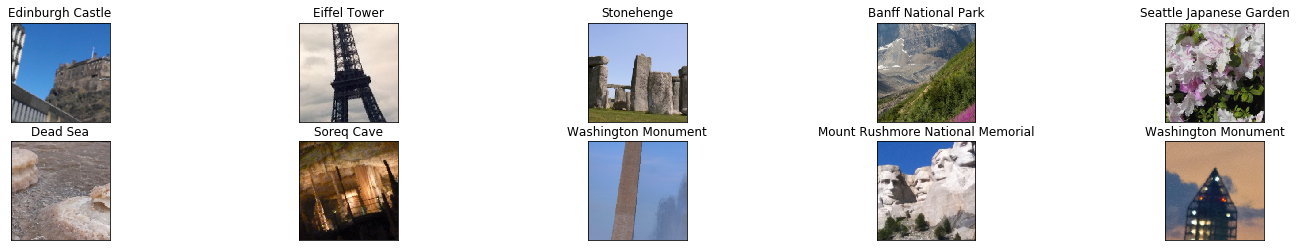

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline
std = torch.tensor([0.229, 0.224, 0.225])
mean = torch.tensor([0.485, 0.456, 0.406])

## TODO: visualize a batch of the train data loader

dataiter = iter(loaders_scratch['train'])
images, labels = dataiter.next()
images = images.numpy() # convert images to numpy for display


## the class names can be accessed at the `classes` attribute
## of your dataset object (e.g., `train_dataset.classes`)|
# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(10):
    ax = fig.add_subplot(2, 5, idx+1, xticks=[], yticks=[])
    plt.imshow(np.transpose(images[idx]*std[:, None, None] + mean[:, None, None], (1, 2, 0)))
    ax.set_title(classes[labels[idx]])


### Initialize use_cuda variable

In [4]:
# useful variable that tells us whether we should use the GPU
use_cuda = torch.cuda.is_available()

### (IMPLEMENTATION) Specify Loss Function and Optimizer

Use the next code cell to specify a [loss function](http://pytorch.org/docs/stable/nn.html#loss-functions) and [optimizer](http://pytorch.org/docs/stable/optim.html).  Save the chosen loss function as `criterion_scratch`, and fill in the function `get_optimizer_scratch` below.

In [5]:
## TODO: select loss function
criterion_scratch = nn.CrossEntropyLoss()

def get_optimizer_scratch(model):
    ## TODO: select and return an optimizer
    return optim.SGD(model.parameters(), lr=0.003, momentum=0.9)
    

### (IMPLEMENTATION) Model Architecture

Create a CNN to classify images of landmarks.  Use the template in the code cell below.

In [6]:
# define the CNN architecture
class Net(nn.Module):
    ## TODO: choose an architecture, and complete the class
    def __init__(self):
        super(Net, self).__init__()
        
        ## Define layers of a CNN
        self.conv1_1 = nn.Conv2d(3, 32, 3, padding=1)
        
        self.conv2_1 = nn.Conv2d(32, 64, 3, padding=1)
        
        self.conv3_1 = nn.Conv2d(64, 128, 3, padding=1)
        
        self.conv4_1 = nn.Conv2d(128, 256, 3, padding=1)
        
        self.conv5_1 = nn.Conv2d(256, 256, 3, padding=1)
        
        self.pool = nn.MaxPool2d(2, 2)
    
        self.fc1 = nn.Linear(12544, 5000)
        self.fc2 = nn.Linear(5000, 1000)
        self.fc3 = nn.Linear(1000, 200)
        self.fc4 = nn.Linear(200, 50)
        
        self.dropout = nn.Dropout2d(0.5)
        
        # batch norm
        self.batchnorm1 = nn.BatchNorm2d(32)
        self.batchnorm2 = nn.BatchNorm2d(64) 
        self.batchnorm3 = nn.BatchNorm2d(128)
        self.batchnorm4 = nn.BatchNorm2d(256)
        self.batchnorm5 = nn.BatchNorm2d(256)
        
        
        self.batchnorm6 = nn.BatchNorm1d(5000)
        self.batchnorm7 = nn.BatchNorm1d(1000)
        self.batchnorm8 = nn.BatchNorm1d(200)
    
    def forward(self, x):
        ## Define forward behavior
        x = F.relu(self.conv1_1(x))
        x = self.pool(x)
        x = self.batchnorm1(x)
        
        x = F.relu(self.conv2_1(x))
        x = self.pool(x)
        x = self.batchnorm2(x)
        
        x = F.relu(self.conv3_1(x))
        x = self.pool(x)
        x = self.batchnorm3(x)
        
        x = F.relu(self.conv4_1(x))
        x = self.pool(x)
        x = self.batchnorm4(x)
        
        x = F.relu(self.conv5_1(x))
        x = self.pool(x)
        x = self.batchnorm5(x)
        
        
        x = x.view(-1,12544)
        
        
        x = self.dropout(x)
        x = F.relu(self.fc1(x))
        x = self.batchnorm6(x)
        
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.batchnorm7(x)
        
        x = self.dropout(x)
        x = F.relu(self.fc3(x))
        x = self.batchnorm8(x)
        
        x = self.dropout(x)
        x = self.fc4(x)
        
        return x

#-#-# Do NOT modify the code below this line. #-#-#

# instantiate the CNN
model_scratch = Net()
print(model_scratch)
# move tensors to GPU if CUDA is available
if use_cuda:
    model_scratch.cuda()

Net(
  (conv1_1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2_1): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3_1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4_1): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv5_1): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=12544, out_features=5000, bias=True)
  (fc2): Linear(in_features=5000, out_features=1000, bias=True)
  (fc3): Linear(in_features=1000, out_features=200, bias=True)
  (fc4): Linear(in_features=200, out_features=50, bias=True)
  (dropout): Dropout2d(p=0.5)
  (batchnorm1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm3): BatchNorm2d(128, eps

__Question 2:__ Outline the steps you took to get to your final CNN architecture and your reasoning at each step.  

__Answer:__ kernal size used for all convolutional layers were 3x3, as when I choose 5x5 the gpu goes out of memory, 5 convilutional layers was used to be followed by a pooling layer to to extract deeper features gradually, and for the fully connected layers 4 layers was used to take the vector size down from 12544 (7x7x256) to 50 (number of classes).

About the learning rate, at first, I started with lr=0.001, and when I finally saw the training progress and the validation loss starting to drop by each epoch, I increased the learning rate up to 0.003, and it started to train much faster.

Note: I used batch normalization after I was struggling to build a CNN that trains by the time then I saw recommendations to add batch normalization after each layer.

### (IMPLEMENTATION) Implement the Training Algorithm

Implement your training algorithm in the code cell below.  [Save the final model parameters](http://pytorch.org/docs/master/notes/serialization.html) at the filepath stored in the variable `save_path`.

In [7]:
def train(n_epochs, loaders, model, optimizer, criterion, use_cuda, save_path, apply_test=False):
    """returns trained model"""
    # initialize tracker for minimum validation loss
    valid_loss_min = np.Inf 
    
    for epoch in range(1, n_epochs+1):
        # initialize variables to monitor training and validation loss
        train_loss = 0.0
        valid_loss = 0.0
        
        ###################
        # train the model #
        ###################
        # set the module to training mode
        model.train()
        for batch_idx, (data, target) in enumerate(loaders['train']):
            # move to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()

            ## TODO: find the loss and update the model parameters accordingly
            ## record the average training loss, using something like
            ## train_loss = train_loss + ((1 / (batch_idx + 1)) * (loss.data.item() - train_loss))
            optimizer.zero_grad()

            output = model(data)
            
            loss = criterion(output, target)
            
            loss.backward()
            
            optimizer.step()
            
            train_loss = train_loss +  ((1 / (batch_idx + 1)) * (loss.item() - train_loss))

        ######################    
        # validate the model #
        ######################
        # set the model to evaluation mode
        model.eval()
        for batch_idx, (data, target) in enumerate(loaders['valid']):          
            
            # move to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()

            ## TODO: update average validation loss 
            output = model(data)             
            loss = criterion(output, target)
            loss.backward()

            valid_loss = valid_loss +  ((1 / (batch_idx + 1)) * (loss.item() - valid_loss))
            

        # print training/validation statistics 
        print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
            epoch, 
            train_loss,
            valid_loss
            ))

        ## TODO: if the validation loss has decreased, save the model at the filepath stored in save_path
        if valid_loss <= valid_loss_min:
            print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
            valid_loss_min,
            valid_loss))
            torch.save(model.state_dict(), save_path)
            valid_loss_min = valid_loss
            
        #if apply_test and epoch %5 == 0:
        #    print('\nTesting results after {} epochs'.format(epoch))
        #    # load the model that got the best validation accuracy
        #   model_test = Net()
        #    if use_cuda:
        #        model_test.cuda()
        #    model_test.load_state_dict(torch.load(save_path))
        #    test(loaders_scratch, model_scratch, criterion_scratch, use_cuda)

    return model

In [8]:
def test(loaders, model, criterion, use_cuda):

    # monitor test loss and accuracy
    test_loss = 0.
    correct = 0.
    total = 0.

    # set the module to evaluation mode
    model.eval()

    for batch_idx, (data, target) in enumerate(loaders['test']):
        # move to GPU
        if use_cuda:
            data, target = data.cuda(), target.cuda()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the loss
        loss = criterion(output, target)
        # update average test loss 
        test_loss = test_loss + ((1 / (batch_idx + 1)) * (loss.data.item() - test_loss))
        # convert output probabilities to predicted class
        pred = output.data.max(1, keepdim=True)[1]
        # compare predictions to true label
        correct += np.sum(np.squeeze(pred.eq(target.data.view_as(pred))).cpu().numpy())
        total += data.size(0)
            
    print('Test Loss: {:.6f}\n'.format(test_loss))

    print('Test Accuracy: %2d%% (%2d/%2d)' % (
        100. * correct / total, correct, total))

### (IMPLEMENTATION) Experiment with the Weight Initialization

Use the code cell below to define a custom weight initialization, and then train with your weight initialization for a few epochs. Make sure that neither the training loss nor validation loss is `nan`.

Later on, you will be able to see how this compares to training with PyTorch's default weight initialization.

In [9]:
def custom_weight_init(m):
    classname = m.__class__.__name__
    ## TODO: implement a weight initialization strategy
    if classname.find('Linear') != -1 or classname.find('Conv2D') != -1 :
        # apply a centered, uniform distribution to the weights
        n = m.in_features
        y = 1.0/np.sqrt(n)
        m.weight.data.normal_(0.0, y)
        m.bias.data.fill_(0)    
    
#-#-# Do NOT modify the code below this line. #-#-#
    
model_scratch.apply(custom_weight_init)
model_scratch = train(5, loaders_scratch, model_scratch, get_optimizer_scratch(model_scratch),
                      criterion_scratch, use_cuda, 'ignore.pt')

Epoch: 1 	Training Loss: 4.129059 	Validation Loss: 3.807374
Validation loss decreased (inf --> 3.807374).  Saving model ...
Epoch: 2 	Training Loss: 3.928628 	Validation Loss: 3.704615
Validation loss decreased (3.807374 --> 3.704615).  Saving model ...
Epoch: 3 	Training Loss: 3.790495 	Validation Loss: 3.614315
Validation loss decreased (3.704615 --> 3.614315).  Saving model ...
Epoch: 4 	Training Loss: 3.686639 	Validation Loss: 3.561798
Validation loss decreased (3.614315 --> 3.561798).  Saving model ...
Epoch: 5 	Training Loss: 3.637417 	Validation Loss: 3.524010
Validation loss decreased (3.561798 --> 3.524010).  Saving model ...


### (IMPLEMENTATION) Train and Validate the Model

Run the next code cell to train your model.

In [10]:
## TODO: you may change the number of epochs if you'd like,
## but changing it is not required
num_epochs = 10

#-#-# Do NOT modify the code below this line. #-#-#

# function to re-initialize a model with pytorch's default weight initialization
def default_weight_init(m):
    reset_parameters = getattr(m, 'reset_parameters', None)
    if callable(reset_parameters):
        m.reset_parameters()

# reset the model parameters
model_scratch.apply(default_weight_init)

# train the model
model_scratch = train(num_epochs, loaders_scratch, model_scratch, get_optimizer_scratch(model_scratch), 
                      criterion_scratch, use_cuda, 'model_scratch.pt', apply_test=True)

Epoch: 1 	Training Loss: 3.944772 	Validation Loss: 3.785693
Validation loss decreased (inf --> 3.785693).  Saving model ...
Epoch: 2 	Training Loss: 3.751116 	Validation Loss: 3.644369
Validation loss decreased (3.785693 --> 3.644369).  Saving model ...
Epoch: 3 	Training Loss: 3.634412 	Validation Loss: 3.564426
Validation loss decreased (3.644369 --> 3.564426).  Saving model ...
Epoch: 4 	Training Loss: 3.544360 	Validation Loss: 3.476550
Validation loss decreased (3.564426 --> 3.476550).  Saving model ...
Epoch: 5 	Training Loss: 3.468362 	Validation Loss: 3.420870
Validation loss decreased (3.476550 --> 3.420870).  Saving model ...
Epoch: 6 	Training Loss: 3.417519 	Validation Loss: 3.440172
Epoch: 7 	Training Loss: 3.355969 	Validation Loss: 3.342626
Validation loss decreased (3.420870 --> 3.342626).  Saving model ...
Epoch: 8 	Training Loss: 3.294667 	Validation Loss: 3.277373
Validation loss decreased (3.342626 --> 3.277373).  Saving model ...
Epoch: 9 	Training Loss: 3.229684 

### (IMPLEMENTATION) Test the Model

Run the code cell below to try out your model on the test dataset of landmark images. Run the code cell below to calculate and print the test loss and accuracy.  Ensure that your test accuracy is greater than 20%.

In [11]:
# load the model that got the best validation accuracy
model_scratch.load_state_dict(torch.load('model_scratch.pt'))
test(loaders_scratch, model_scratch, criterion_scratch, use_cuda)

Test Loss: 3.151213

Test Accuracy: 22% (278/1250)


---
<a id='step2'></a>
## Step 2: Create a CNN to Classify Landmarks (using Transfer Learning)

You will now use transfer learning to create a CNN that can identify landmarks from images.  Your CNN must attain at least 60% accuracy on the test set.

### (IMPLEMENTATION) Specify Data Loaders for the Landmark Dataset

Use the code cell below to create three separate [data loaders](http://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader): one for training data, one for validation data, and one for test data. Randomly split the images located at `landmark_images/train` to create the train and validation data loaders, and use the images located at `landmark_images/test` to create the test data loader.

All three of your data loaders should be accessible via a dictionary named `loaders_transfer`. Your train data loader should be at `loaders_transfer['train']`, your validation data loader should be at `loaders_transfer['valid']`, and your test data loader should be at `loaders_transfer['test']`.

If you like, **you are welcome to use the same data loaders from the previous step**, when you created a CNN from scratch.

In [12]:
### TODO: Write data loaders for training, validation, and test sets
## Specify appropriate transforms, and batch_sizes

# number of subprocesses to use for data loading
num_workers = 0
# how many samples per batch to load
batch_size = 100
# percentage of training set to use as validation
valid_size = 0.2

data_dir = 'landmark_images/'
train_dir = os.path.join(data_dir, 'train/')
test_dir = os.path.join(data_dir, 'test/')

train_transform = transforms.Compose([transforms.RandomResizedCrop(size=512, scale=(1.0, 1.0)),
                                transforms.RandomRotation(degrees=15),
                                transforms.RandomHorizontalFlip(),
                                transforms.CenterCrop(size=224),
                                transforms.ToTensor(),
                                transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
                                ])

data_transform = transforms.Compose([transforms.Resize(400),
                                transforms.CenterCrop(size=224),
                                transforms.ToTensor(),
                                transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
                                ])

train_data = datasets.ImageFolder(train_dir, transform=train_transform)
valid_data = datasets.ImageFolder(train_dir, transform=data_transform)
test_data = datasets.ImageFolder(test_dir, transform=data_transform)

# obtain training indices that will be used for validation
num_train = len(train_data)
indices = list(range(num_train))
np.random.shuffle(indices)
split = int(np.floor(valid_size * num_train))
train_idx, valid_idx = indices[split:], indices[:split]

# define samplers for obtaining training and validation batches
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

# prepare data loaders (combine dataset and sampler)
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size,
    sampler=train_sampler, num_workers=num_workers)
valid_loader = torch.utils.data.DataLoader(valid_data, batch_size=batch_size, 
    sampler=valid_sampler, num_workers=num_workers)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, 
    num_workers=num_workers)

loaders_transfer = {'train': train_loader, 'valid': valid_loader, 'test': test_loader}

classes = ['Haleakala National Park', 'Mount Rainier National_Park',
            'Ljubljana Castle', 'Dead Sea', 'Wroclaws Dwarves', 
            'London Olympic Stadium', 'Niagara Falls', 'Stonehenge',
            'Grand Canyon', 'Golden Gate Bridge', 'Edinburgh Castle',
            'Mount Rushmore National Memorial', 'Kantanagar Temple', 'Yellowstone National Park',
            'Terminal Tower', 'Central Park', 'Eiffel Tower',
            'Changdeokgung', 'Delicate Arch', 'Vienna City Hall',
            'Matterhorn', 'Taj Mahal', 'Moscow Raceway',
            'Externsteine', 'Soreq Cave', 'Banff National Park',
            'Pont du Gard', 'Seattle Japanese Garden', 'Sydney Harbour Bridge',
            'Petronas Towers', 'Brooklyn Bridge', 'Washington Monument',
            'Hanging Temple', 'Sydney Opera House', 'Great Barrier Reef',
            'Monumento a la Revolucion', 'Badlands National Park', 'Atomium',
            'Forth Bridge', 'Gateway of India', 'Stockholm City Hall',
            'Machu Picchu', 'Death Valley National Park', 'Gullfoss Falls',
            'Trevi Fountain', 'Temple of Heaven', 'Great Wall of China',
            'Prague Astronomical Clock', 'Whitby Abbey', 'Temple of Olympian Zeus']

### (IMPLEMENTATION) Specify Loss Function and Optimizer

Use the next code cell to specify a [loss function](http://pytorch.org/docs/stable/nn.html#loss-functions) and [optimizer](http://pytorch.org/docs/stable/optim.html).  Save the chosen loss function as `criterion_transfer`, and fill in the function `get_optimizer_transfer` below.

In [13]:
criterion_transfer = nn.CrossEntropyLoss()

def get_optimizer_transfer(model):
    return optim.SGD(model.classifier.parameters(), lr=0.003, momentum=0.9)

### (IMPLEMENTATION) Model Architecture

Use transfer learning to create a CNN to classify images of landmarks.  Use the code cell below, and save your initialized model as the variable `model_transfer`.

In [43]:
## TODO: Specify model architecture

model_transfer = models.vgg16(pretrained=True)

# Freeze training for all "features" layers
for param in model_transfer.features.parameters():
    param.requires_grad = False
    
last_layer = nn.Linear(model_transfer.classifier[6].in_features, len(classes))
model_transfer.classifier[6] = last_layer

print(model_transfer)


#-#-# Do NOT modify the code below this line. #-#-#

if use_cuda:
    model_transfer = model_transfer.cuda()

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (17): Conv2d

__Question 3:__ Outline the steps you took to get to your final CNN architecture and your reasoning at each step.  Describe why you think the architecture is suitable for the current problem.

__Answer:__ I searched for the best CNN's to use for the problem here (image classification) and the VGG16 was one of the recommended CNN's, then used it as my trained CNN with output vector of size 50, and with training for only 2 epochs the model had an accuracy of 65%, which was sufficient for this problem.  

### (IMPLEMENTATION) Train and Validate the Model

Train and validate your model in the code cell below.  [Save the final model parameters](http://pytorch.org/docs/master/notes/serialization.html) at filepath `'model_transfer.pt'`.

In [44]:
# TODO: train the model and save the best model parameters at filepath 'model_transfer.pt'

n_epochs = 2
valid_loss_min = np.Inf 

optimizer = get_optimizer_transfer(model_transfer)

for epoch in range(1, n_epochs+1):

    # keep track of training and validation loss
    train_loss = 0.0
    valid_loss = 0.0
    
    ###################
    # train the model #
    ###################
    # model by default is set to train
    model_transfer.train()
    for batch_idx, (data, target) in enumerate(loaders_transfer['train']):
        # move tensors to GPU if CUDA is available
        if use_cuda:
            data, target = data.cuda(), target.cuda()
        # clear the gradients of all optimized variables
        optimizer.zero_grad()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model_transfer(data)
        # calculate the batch loss
        loss = criterion_transfer(output, target)
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizer.step()
        # update training loss 
        train_loss =  train_loss +  ((1 / (batch_idx + 1)) * (loss.item() - train_loss))
        
    ######################    
    # validate the model #
    ######################
    # set the model to evaluation mode
    model_transfer.eval()
    for batch_idx, (data, target) in enumerate(loaders_transfer['valid']):          

        # move to GPU
        if use_cuda:
            data, target = data.cuda(), target.cuda()

        ## TODO: update average validation loss 
        output = model_transfer(data)             
        loss = criterion_transfer(output, target)
        loss.backward()

        valid_loss = valid_loss +  ((1 / (batch_idx + 1)) * (loss.item() - valid_loss))


    # print training/validation statistics 
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
        epoch, 
        train_loss,
        valid_loss
        ))
    
    # Saving a better model
    if valid_loss <= valid_loss_min:
            print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
            valid_loss_min,
            valid_loss))
            torch.save(model_transfer.state_dict(), 'model_transfer.pt')
            valid_loss_min = valid_loss



Epoch: 1 	Training Loss: 3.113490 	Validation Loss: 1.902980
Validation loss decreased (inf --> 1.902980).  Saving model ...
Epoch: 2 	Training Loss: 1.802417 	Validation Loss: 1.386354
Validation loss decreased (1.902980 --> 1.386354).  Saving model ...


### (IMPLEMENTATION) Test the Model

Try out your model on the test dataset of landmark images. Use the code cell below to calculate and print the test loss and accuracy.  Ensure that your test accuracy is greater than 60%.

In [45]:
#-#-# Do NOT modify the code below this line. #-#-#

# load the model that got the best validation accuracy
model_transfer.load_state_dict(torch.load('model_transfer.pt'))
test(loaders_transfer, model_transfer, criterion_transfer, use_cuda)

Test Loss: 1.279480

Test Accuracy: 65% (815/1250)


---
<a id='step3'></a>
## Step 3: Write Your Landmark Prediction Algorithm

Great job creating your CNN models! Now that you have put in all the hard work of creating accurate classifiers, let's define some functions to make it easy for others to use your classifiers.

### (IMPLEMENTATION) Write Your Algorithm, Part 1

Implement the function `predict_landmarks`, which accepts a file path to an image and an integer k, and then predicts the **top k most likely landmarks**. You are **required** to use your transfer learned CNN from Step 2 to predict the landmarks.

An example of the expected behavior of `predict_landmarks`:
```
>>> predicted_landmarks = predict_landmarks('example_image.jpg', 3)
>>> print(predicted_landmarks)
['Golden Gate Bridge', 'Brooklyn Bridge', 'Sydney Harbour Bridge']
```

In [2]:
import cv2
from PIL import Image

## the class names can be accessed at the `classes` attribute
## of your dataset object (e.g., `train_dataset.classes`)


classes = ['Haleakala National Park', 'Mount Rainier National Park',
            'Ljubljana Castle', 'Dead Sea', 'Wroclaws Dwarves', 
            'London Olympic Stadium', 'Niagara Falls', 'Stonehenge',
            'Grand Canyon', 'Golden Gate Bridge', 'Edinburgh Castle',
            'Mount Rushmore National Memorial', 'Kantanagar Temple', 'Yellowstone National Park',
            'Terminal Tower', 'Central Park', 'Eiffel Tower',
            'Changdeokgung', 'Delicate Arch', 'Vienna City Hall',
            'Matterhorn', 'Taj Mahal', 'Moscow Raceway',
            'Externsteine', 'Soreq Cave', 'Banff National Park',
            'Pont du Gard', 'Seattle Japanese Garden', 'Sydney Harbour Bridge',
            'Petronas Towers', 'Brooklyn Bridge', 'Washington Monument',
            'Hanging Temple', 'Sydney Opera House', 'Great Barrier Reef',
            'Monumento a la Revolucion', 'Badlands National Park', 'Atomium',
            'Forth Bridge', 'Gateway of India', 'Stockholm City Hall',
            'Machu Picchu', 'Death Valley National Park', 'Gullfoss Falls',
            'Trevi Fountain', 'Temple of Heaven', 'Great Wall of China',
            'Prague Astronomical Clock', 'Whitby Abbey', 'Temple of Olympian Zeus']

model_transfer = models.vgg16(pretrained=False)
last_layer = nn.Linear(model_transfer.classifier[6].in_features, len(classes))
model_transfer.classifier[6] = last_layer
model_transfer.load_state_dict(torch.load('model_transfer.pt'))

data_transform = transforms.Compose([transforms.Resize(400),
                                transforms.CenterCrop(size=224),
                                transforms.ToTensor(),
                                transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
                                ])


def predict_landmarks(img_path, k):
    ## TODO: return the names of the top k landmarks predicted by the transfer learned CNN
    
    img = Image.open(img_path)
    img = data_transform(img)
    
    model_transfer.eval()

    idx = torch.topk(model_transfer(img.view(1,3,224,224)),k)
    idx = idx[1][0]

    my_list = []
    for i in idx:
        my_list.append(classes[i])
        
    return my_list
    

In [3]:
# test on a sample image
pl = predict_landmarks('images/test/09.Golden_Gate_Bridge/190f3bae17c32c37.jpg', 3)
print(pl)

['Golden Gate Bridge', 'Forth Bridge', 'Sydney Harbour Bridge']


### (IMPLEMENTATION) Write Your Algorithm, Part 2

In the code cell below, implement the function `suggest_locations`, which accepts a file path to an image as input, and then displays the image and the **top 3 most likely landmarks** as predicted by `predict_landmarks`.

Some sample output for `suggest_locations` is provided below, but feel free to design your own user experience!
![](images/sample_landmark_output.png)

Is this picture of the
Golden Gate Bridge, Forth Bridge, or Sydney Harbour Bridge?


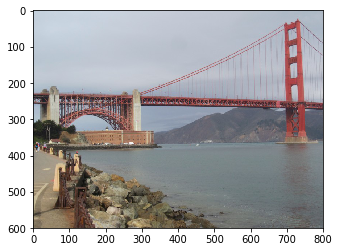

In [4]:
def suggest_locations(img_path):
    # get landmark predictions
    predicted_landmarks = predict_landmarks(img_path, 3)
    
    ## TODO: display image and display landmark predictions
    img = mpimg.imread(img_path)
    imgplot = plt.imshow(img)
    print('Is this picture of the')
    
    print(predicted_landmarks[0] + ', ' + predicted_landmarks[1] + ', or ' + predicted_landmarks[2] + '?')
    

# test on a sample image
suggest_locations('images/test/09.Golden_Gate_Bridge/190f3bae17c32c37.jpg')

### (IMPLEMENTATION) Test Your Algorithm

Test your algorithm by running the `suggest_locations` function on at least four images on your computer. Feel free to use any images you like.

__Question 4:__ Is the output better than you expected :) ?  Or worse :( ?  Provide at least three possible points of improvement for your algorithm.

__Answer:__ (Three possible points for improvement)

A1: The output is better than I expected as it got the four random pictures right, and now the model knows more landmarks than I do :D

A2:

1. The model can be trained for more epochs (not just 2) to get better accuracy.
2. The augmentation used for the training dataset could be more than what has been applied above, could include more rotation range, crop from random positions not just from the center, randomly change the light intensity could be added.
3. Could have used a much deeper pre-trained model that may also have larger input image dimensions, to reach much better accuracy.

Is this picture of the
Atomium, London Olympic Stadium, or Mount Rainier National_Park?


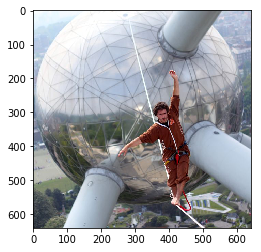

In [5]:
## TODO: Execute the `suggest_locations` function on
## at least 4 images on your computer.
## Feel free to use as many code cells as needed.

# Note: these 4 images I got them from google

suggest_locations('suggest_this_locations/Atomium.jpg')

Is this picture of the
Eiffel Tower, Edinburgh Castle, or Vienna City Hall?


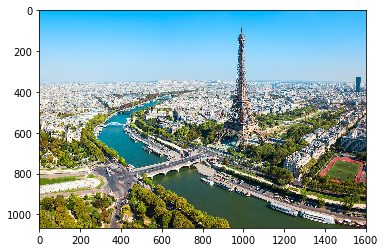

In [6]:
suggest_locations('suggest_this_locations/Eiffer-Tower.jpg')

Is this picture of the
Grand Canyon, Externsteine, or Delicate Arch?


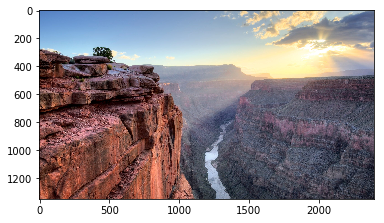

In [7]:
suggest_locations('suggest_this_locations/Grand-Canyon.jpg')

Is this picture of the
Stockholm City Hall, Temple of Heaven, or Ljubljana Castle?


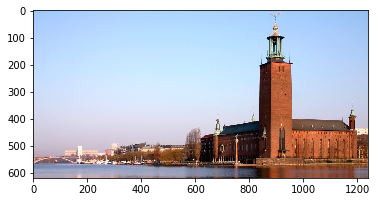

In [8]:
suggest_locations('suggest_this_locations/Stockholm-City-Hall.jpg')

Is this picture of the
Yellowstone National Park, Banff National Park, or Mount Rainier National_Park?


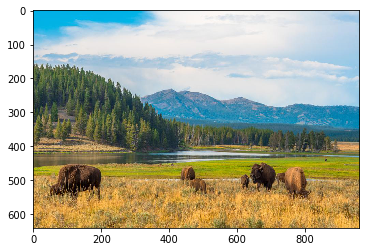

In [9]:
suggest_locations('suggest_this_locations/Yellowstone-National-Park.jpg')